# Time series - TensorFlow

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

import os, sys
sys.path.insert(0, os.path.abspath('../src'))

from ts import *
from utils import *
from tfts import *

import tensorflow as tf

In [2]:
data_path = "../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, _, _, _ = load_data(data_path)

In [5]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

In [6]:
df = covidpro_df[covidpro_df.Province == province].query('20200801 > Date')

In [7]:
df = df.set_index(date)

In [8]:
df = df.loc[:, ['New_cases', 'Deaths']]
#df = df.loc[:, ['New_cases']]

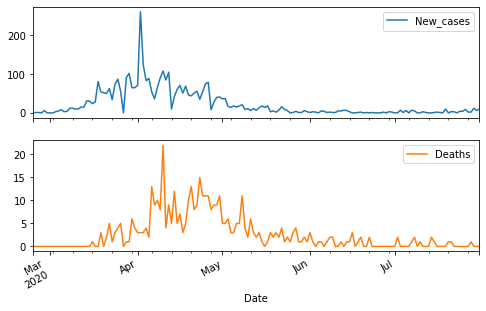

In [9]:
df.plot(subplots=True, figsize=(8,5))
plt.show()

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
New_cases,159.0,22.817610,34.652498,0.0,1.0,7.0,35.5,261.0
Deaths,159.0,2.622642,3.742806,0.0,0.0,1.0,3.5,22.0


In [11]:
# Make it stationary, remove trend and seasonality
res = np.log(df[compart]) - np.log(df[compart]).shift(1)
res_fix = res.replace([np.inf, -np.inf], np.nan).interpolate(method='time')

res_fix.dropna(inplace=True)

decomposed = seasonal_decompose(res_fix,model='additive',extrapolate_trend='freq')
detrended = res_fix - decomposed.trend
deseasonalized = detrended / decomposed.seasonal

In [12]:
adf_test(deseasonalized.values)
kpss_test(deseasonalized.values)

ADF Statistic: -10.083327962059796
p-value: 1.1728864852470525e-17
Critial Values:
   1%, -3.4729792729247793
Critial Values:
   5%, -2.8802520918255534
Critial Values:
   10%, -2.5767469641683105

KPSS Statistic: 0.093547
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


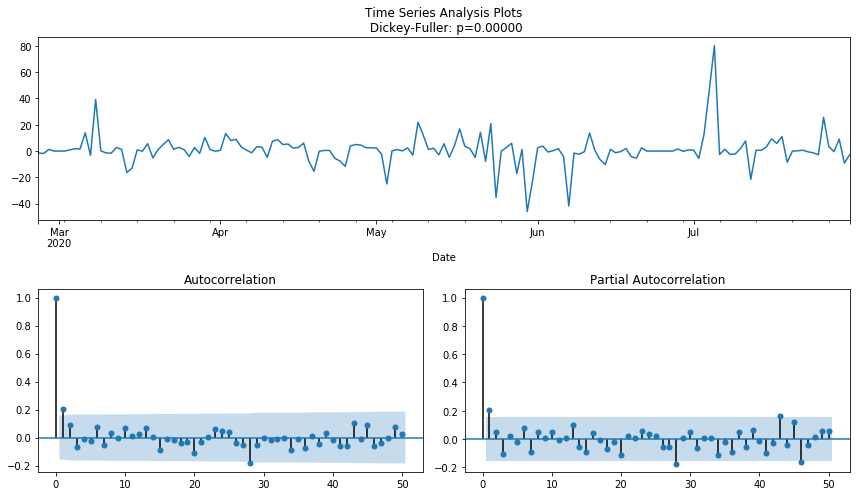

In [13]:
tsplot(deseasonalized, lags=50)

In [14]:
df = pd.DataFrame(deseasonalized, columns=[compart])

In [15]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [16]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Single step

In [17]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])
    
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['New_cases']

In [18]:
baseline = Baseline(label_index=column_indices[compart])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(), 
                          tf.metrics.MeanSquaredError()])

val_performance = {}
performance = {}

In [19]:
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 3.1525 - mean_absolute_error: 0.8639 - mean_squared_error: 3.1525


In [20]:
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

### Wide window

In [21]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

wide_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label column name(s): ['New_cases']

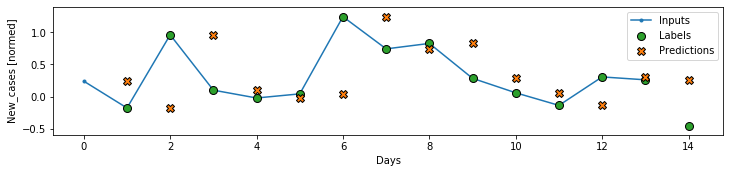

In [22]:
wide_window.plot(baseline)

In [23]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [24]:
history = compile_and_fit(linear, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 44ms/step - loss: 2.0054 - mean_absolute_error: 0.9170 - mean_squared_error: 2.0054 - val_loss: 6.8693 - val_mean_absolute_error: 1.0637 - val_mean_squared_error: 6.8693
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 1.9984 - mean_absolute_error: 0.9154 - mean_squared_error: 1.9984 - val_loss: 6.8429 - val_mean_absolute_error: 1.0616 - val_mean_squared_error: 6.8429
Epoch 3/50
4/4 [==============================] - 0s 17ms/step - loss: 1.9912 - mean_absolute_error: 0.9140 - mean_squared_error: 1.9912 - val_loss: 6.8176 - val_mean_absolute_error: 1.0598 - val_mean_squared_error: 6.8176
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 1.9828 - mean_absolute_error: 0.9123 - mean_squared_error: 1.9828 - val_loss: 6.7937 - val_mean_absolute_error: 1.0578 - val_mean_squared_error: 6.7937
Epoch 5/50
4/4 [==============================] - 0s 21ms/step - loss: 1.9762 - mean_absolute_error: 0.9109 

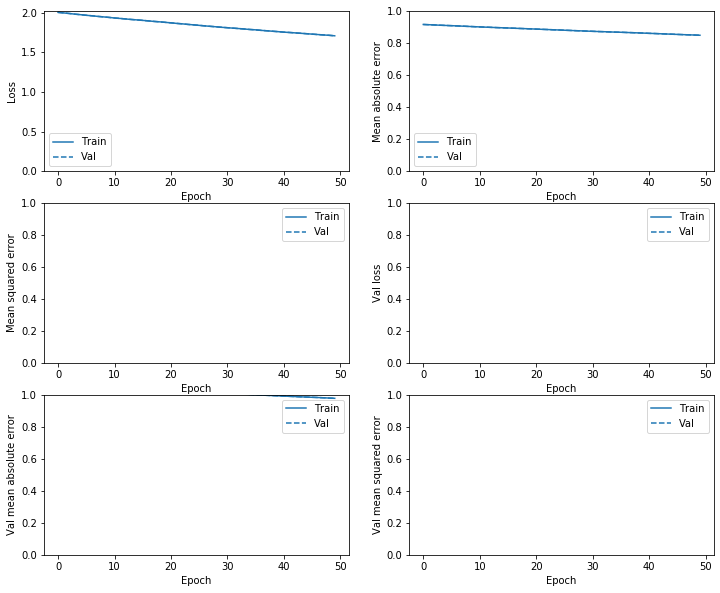

In [25]:
plot_metrics(history)

In [26]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 5.8109 - mean_absolute_error: 0.9787 - mean_squared_error: 5.8109


In [27]:
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

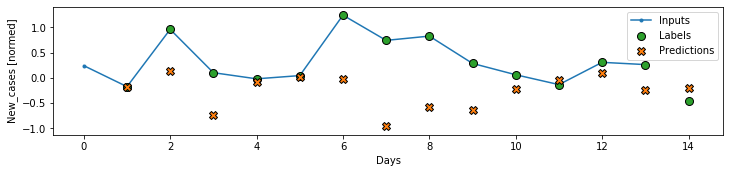

In [28]:
wide_window.plot(linear)

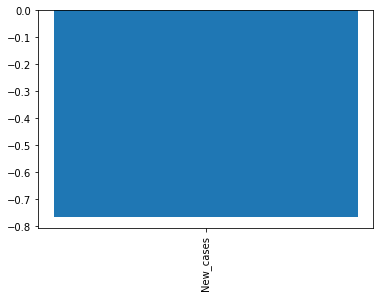

In [29]:
# Show weights
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
axis.set_xticklabels(train_df.columns, rotation=90)
plt.show()

In [30]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 63ms/step - loss: 0.9903 - mean_absolute_error: 0.6004 - mean_squared_error: 0.9903 - val_loss: 2.5690 - val_mean_absolute_error: 0.6465 - val_mean_squared_error: 2.5690
Epoch 2/50
4/4 [==============================] - 0s 18ms/step - loss: 0.9862 - mean_absolute_error: 0.5887 - mean_squared_error: 0.9862 - val_loss: 2.6715 - val_mean_absolute_error: 0.6364 - val_mean_squared_error: 2.6715
Epoch 3/50
4/4 [==============================] - 0s 22ms/step - loss: 0.9857 - mean_absolute_error: 0.5916 - mean_squared_error: 0.9857 - val_loss: 2.7545 - val_mean_absolute_error: 0.6439 - val_mean_squared_error: 2.7545


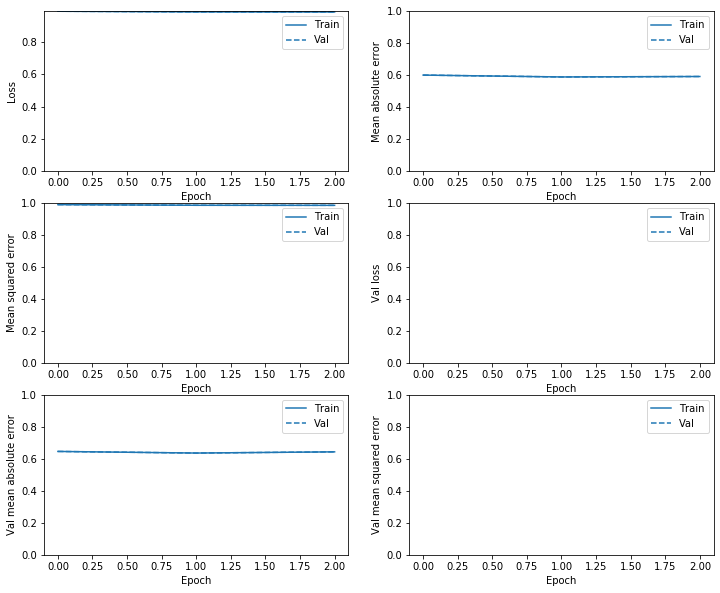

In [31]:
plot_metrics(history)

In [32]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 2.7545 - mean_absolute_error: 0.6439 - mean_squared_error: 2.7545


In [33]:
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [34]:
CONV_WIDTH = 14
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

conv_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14]
Label column name(s): ['New_cases']

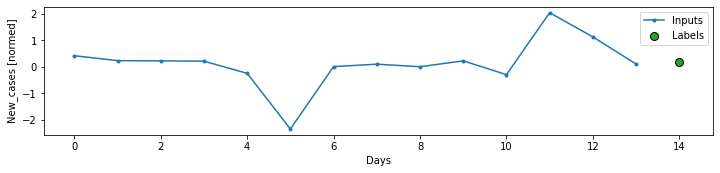

In [35]:
conv_window.plot()

In [36]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [37]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/50
3/3 [==============================] - 0s 58ms/step - loss: 1.1001 - mean_absolute_error: 0.7338 - mean_squared_error: 1.1001 - val_loss: 4.5919 - val_mean_absolute_error: 1.2291 - val_mean_squared_error: 4.5919
Epoch 2/50
3/3 [==============================] - 0s 23ms/step - loss: 1.0381 - mean_absolute_error: 0.7064 - mean_squared_error: 1.0381 - val_loss: 4.5745 - val_mean_absolute_error: 1.2095 - val_mean_squared_error: 4.5745
Epoch 3/50
3/3 [==============================] - 0s 22ms/step - loss: 0.9909 - mean_absolute_error: 0.6849 - mean_squared_error: 0.9909 - val_loss: 4.5517 - val_mean_absolute_error: 1.2027 - val_mean_squared_error: 4.5517
Epoch 4/50
3/3 [==============================] - 0s 24ms/step - loss: 0.9469 - mean_absolute_error: 0.6639 - mean_squared_error: 0.9469 - val_loss: 4.5476 - val_mean_absolute_error: 1.2006 - val_mean_squared_error: 4.5476
Epoch 5/50
3/3 [==============================] - 0s 30ms/step - loss: 0.9094 - mean_absolute_error: 0.6466 

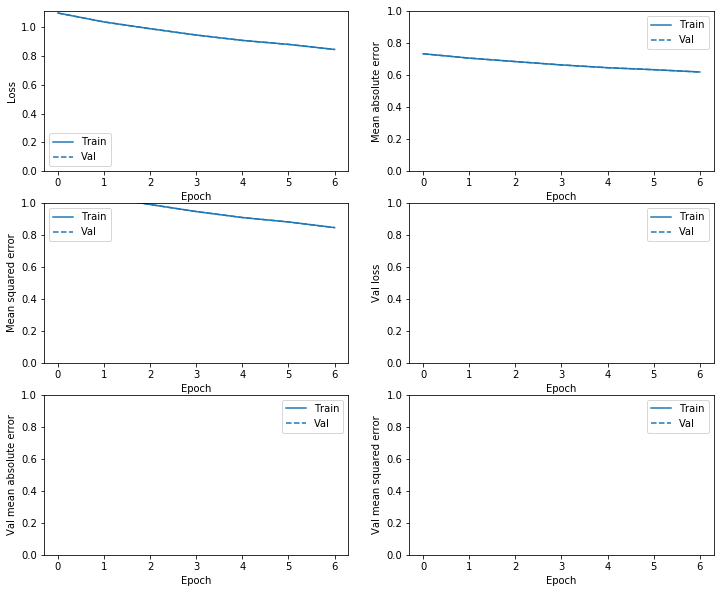

In [38]:
plot_metrics(history)

In [39]:
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 4.5401 - mean_absolute_error: 1.1947 - mean_squared_error: 4.5401


In [40]:
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

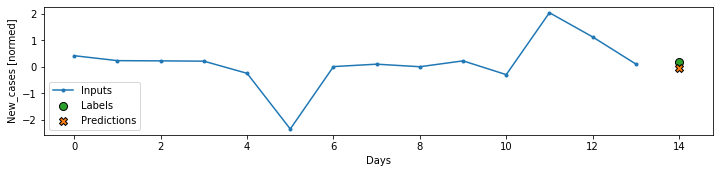

In [41]:
conv_window.plot(multi_step_dense)

In [42]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [43]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
3/3 [==============================] - 1s 173ms/step - loss: 0.9911 - mean_absolute_error: 0.6030 - mean_squared_error: 0.9911 - val_loss: 3.4721 - val_mean_absolute_error: 0.7542 - val_mean_squared_error: 3.4721
Epoch 2/50
3/3 [==============================] - 0s 26ms/step - loss: 0.9881 - mean_absolute_error: 0.6059 - mean_squared_error: 0.9881 - val_loss: 3.4602 - val_mean_absolute_error: 0.7576 - val_mean_squared_error: 3.4602
Epoch 3/50
3/3 [==============================] - 0s 27ms/step - loss: 0.9860 - mean_absolute_error: 0.6062 - mean_squared_error: 0.9860 - val_loss: 3.4460 - val_mean_absolute_error: 0.7595 - val_mean_squared_error: 3.4460
Epoch 4/50
3/3 [==============================] - 0s 27ms/step - loss: 0.9844 - mean_absolute_error: 0.6061 - mean_squared_error: 0.9844 - val_loss: 3.4350 - val_mean_absolute_error: 0.7616 - val_mean_squared_error: 3.4350
Epoch 5/50
3/3 [==============================] - 0s 29ms/step - loss: 0.9829 - mean_absolute_error: 0.6066

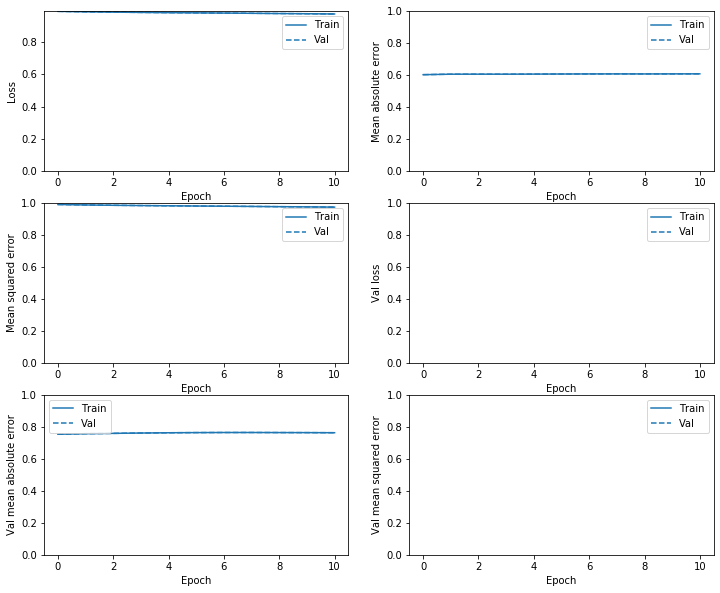

In [44]:
plot_metrics(history)

In [45]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 3.4070 - mean_absolute_error: 0.7636 - mean_squared_error: 3.4070


In [46]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

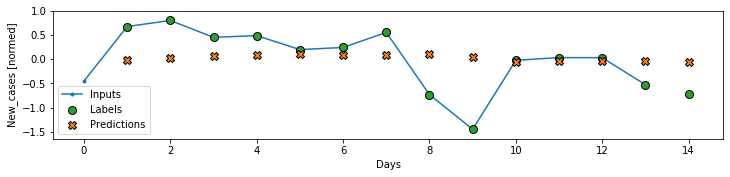

In [47]:
wide_window.plot(lstm_model)

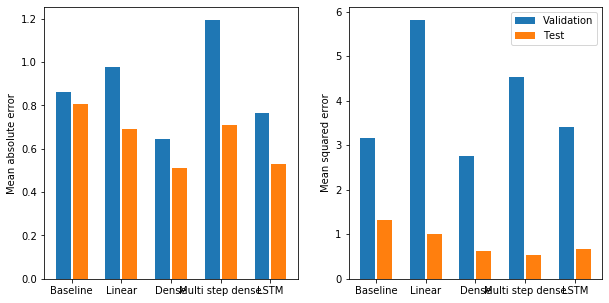

In [48]:
plot_comparison_results(lstm_model.metrics_names, val_performance, performance)

### Multi-output

In [49]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

In [50]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

In [51]:
val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(wide_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 3.6707 - mean_absolute_error: 0.9065 - mean_squared_error: 3.6707


In [52]:
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

In [53]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [54]:
history = compile_and_fit(dense, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 41ms/step - loss: 1.0051 - mean_absolute_error: 0.5948 - mean_squared_error: 1.0051 - val_loss: 2.6839 - val_mean_absolute_error: 0.6367 - val_mean_squared_error: 2.6839
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 0.9816 - mean_absolute_error: 0.5921 - mean_squared_error: 0.9816 - val_loss: 2.7596 - val_mean_absolute_error: 0.6521 - val_mean_squared_error: 2.7596
Epoch 3/50
4/4 [==============================] - 0s 17ms/step - loss: 0.9856 - mean_absolute_error: 0.6065 - mean_squared_error: 0.9856 - val_loss: 2.8054 - val_mean_absolute_error: 0.6655 - val_mean_squared_error: 2.8054


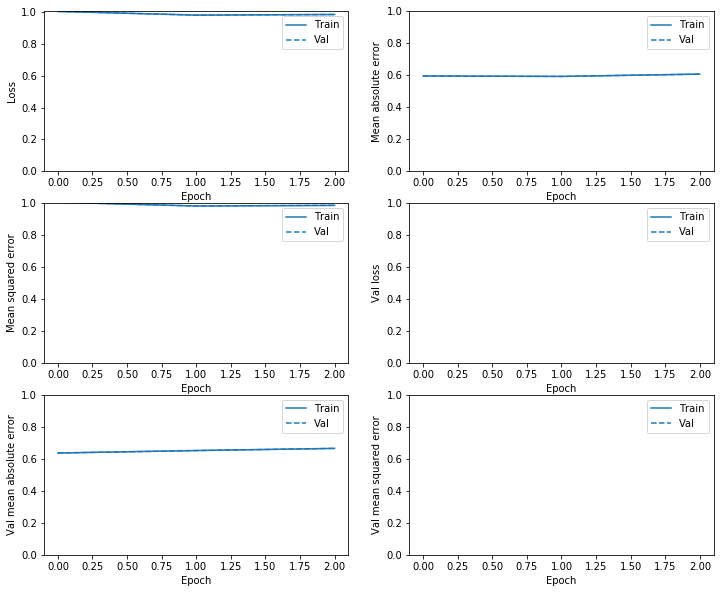

In [55]:
plot_metrics(history)

In [56]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 2.8054 - mean_absolute_error: 0.6655 - mean_squared_error: 2.8054


In [57]:
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [58]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
3/3 [==============================] - 0s 127ms/step - loss: 1.0152 - mean_absolute_error: 0.6034 - mean_squared_error: 1.0152 - val_loss: 3.4485 - val_mean_absolute_error: 0.7582 - val_mean_squared_error: 3.4485
Epoch 2/50
3/3 [==============================] - 0s 21ms/step - loss: 1.0095 - mean_absolute_error: 0.6027 - mean_squared_error: 1.0095 - val_loss: 3.4425 - val_mean_absolute_error: 0.7577 - val_mean_squared_error: 3.4425
Epoch 3/50
3/3 [==============================] - 0s 24ms/step - loss: 1.0042 - mean_absolute_error: 0.6026 - mean_squared_error: 1.0042 - val_loss: 3.4300 - val_mean_absolute_error: 0.7604 - val_mean_squared_error: 3.4300
Epoch 4/50
3/3 [==============================] - 0s 26ms/step - loss: 1.0001 - mean_absolute_error: 0.6028 - mean_squared_error: 1.0001 - val_loss: 3.4197 - val_mean_absolute_error: 0.7652 - val_mean_squared_error: 3.4197
Epoch 5/50
3/3 [==============================] - 0s 24ms/step - loss: 0.9971 - mean_absolute_error: 0.6043

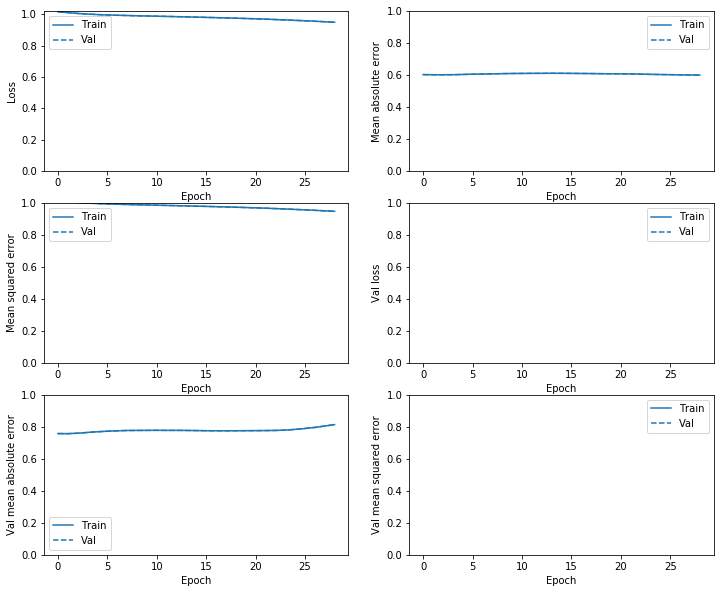

In [59]:
plot_metrics(history)

In [60]:
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)

1/1 [==============================] - 0s 991us/step - loss: 3.3253 - mean_absolute_error: 0.8143 - mean_squared_error: 3.3253


In [61]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [62]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

Epoch 1/50
3/3 [==============================] - 1s 186ms/step - loss: 1.8343 - mean_absolute_error: 0.8634 - mean_squared_error: 1.8343 - val_loss: 3.6614 - val_mean_absolute_error: 0.9068 - val_mean_squared_error: 3.6614
Epoch 2/50
3/3 [==============================] - 0s 22ms/step - loss: 1.8287 - mean_absolute_error: 0.8615 - mean_squared_error: 1.8287 - val_loss: 3.6521 - val_mean_absolute_error: 0.9075 - val_mean_squared_error: 3.6521
Epoch 3/50
3/3 [==============================] - 0s 22ms/step - loss: 1.8227 - mean_absolute_error: 0.8594 - mean_squared_error: 1.8227 - val_loss: 3.6427 - val_mean_absolute_error: 0.9081 - val_mean_squared_error: 3.6427
Epoch 4/50
3/3 [==============================] - 0s 20ms/step - loss: 1.8168 - mean_absolute_error: 0.8575 - mean_squared_error: 1.8168 - val_loss: 3.6332 - val_mean_absolute_error: 0.9087 - val_mean_squared_error: 3.6332
Epoch 5/50
3/3 [==============================] - 0s 24ms/step - loss: 1.8108 - mean_absolute_error: 0.8555

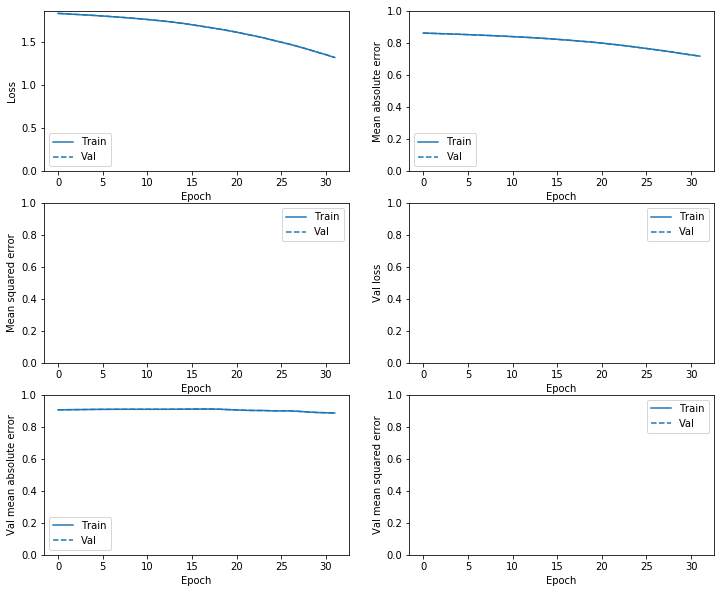

In [63]:
plot_metrics(history)

In [64]:
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)

1/1 [==============================] - 0s 3ms/step - loss: 3.3285 - mean_absolute_error: 0.8869 - mean_squared_error: 3.3285


In [65]:
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

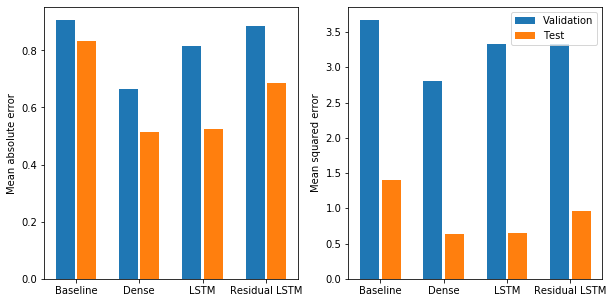

In [66]:
plot_comparison_results(lstm_model.metrics_names, val_performance, performance)

## Multi-step

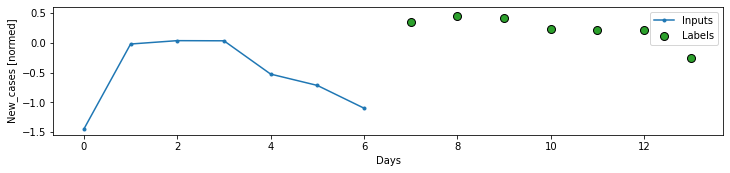

In [171]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
    train_df=train_df, val_df=val_df, test_df=test_df)

multi_window.plot()

In [172]:
last_baseline = MultiStepLastBaseline(OUT_STEPS)
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)

In [173]:
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

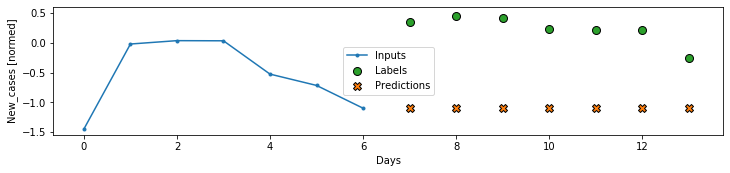

In [174]:
multi_window.plot(last_baseline)

In [175]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, verbose=0)

In [176]:
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)

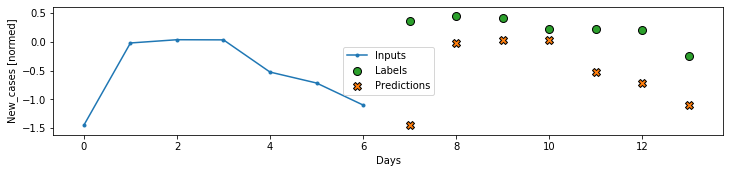

In [177]:
multi_window.plot(repeat_baseline)

### Single shot

In [178]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

Epoch 1/50
3/3 [==============================] - 1s 213ms/step - loss: 1.0610 - mean_absolute_error: 0.6163 - mean_squared_error: 1.0610 - val_loss: 4.1472 - val_mean_absolute_error: 0.8705 - val_mean_squared_error: 4.1472
Epoch 2/50
3/3 [==============================] - 0s 23ms/step - loss: 1.0606 - mean_absolute_error: 0.6162 - mean_squared_error: 1.0606 - val_loss: 4.1465 - val_mean_absolute_error: 0.8705 - val_mean_squared_error: 4.1465
Epoch 3/50
3/3 [==============================] - 0s 24ms/step - loss: 1.0602 - mean_absolute_error: 0.6163 - mean_squared_error: 1.0602 - val_loss: 4.1456 - val_mean_absolute_error: 0.8706 - val_mean_squared_error: 4.1456
Epoch 4/50
3/3 [==============================] - 0s 26ms/step - loss: 1.0600 - mean_absolute_error: 0.6164 - mean_squared_error: 1.0600 - val_loss: 4.1450 - val_mean_absolute_error: 0.8706 - val_mean_squared_error: 4.1450
Epoch 5/50
3/3 [==============================] - 0s 21ms/step - loss: 1.0597 - mean_absolute_error: 0.6164

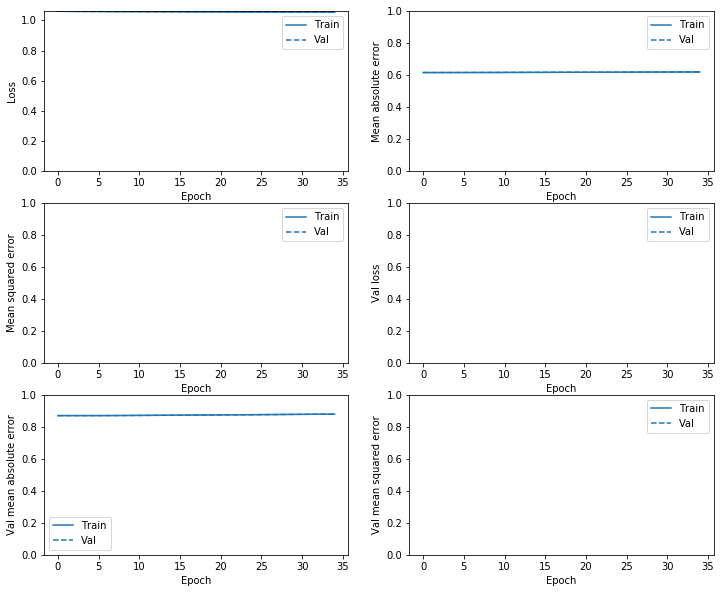

In [179]:
plot_metrics(history)

In [180]:
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 4.1356 - mean_absolute_error: 0.8800 - mean_squared_error: 4.1356


In [181]:
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

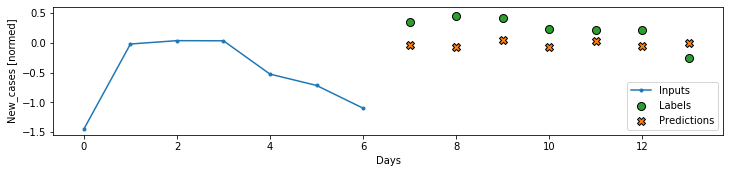

In [182]:
multi_window.plot(multi_linear_model)

In [183]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

Epoch 1/50
3/3 [==============================] - 0s 60ms/step - loss: 1.0601 - mean_absolute_error: 0.6170 - mean_squared_error: 1.0601 - val_loss: 4.1543 - val_mean_absolute_error: 0.8714 - val_mean_squared_error: 4.1543
Epoch 2/50
3/3 [==============================] - 0s 19ms/step - loss: 1.0522 - mean_absolute_error: 0.6177 - mean_squared_error: 1.0522 - val_loss: 4.1500 - val_mean_absolute_error: 0.8802 - val_mean_squared_error: 4.1500
Epoch 3/50
3/3 [==============================] - 0s 21ms/step - loss: 1.0471 - mean_absolute_error: 0.6203 - mean_squared_error: 1.0471 - val_loss: 4.1583 - val_mean_absolute_error: 0.8892 - val_mean_squared_error: 4.1583
Epoch 4/50
3/3 [==============================] - 0s 21ms/step - loss: 1.0427 - mean_absolute_error: 0.6217 - mean_squared_error: 1.0427 - val_loss: 4.1665 - val_mean_absolute_error: 0.8958 - val_mean_squared_error: 4.1665


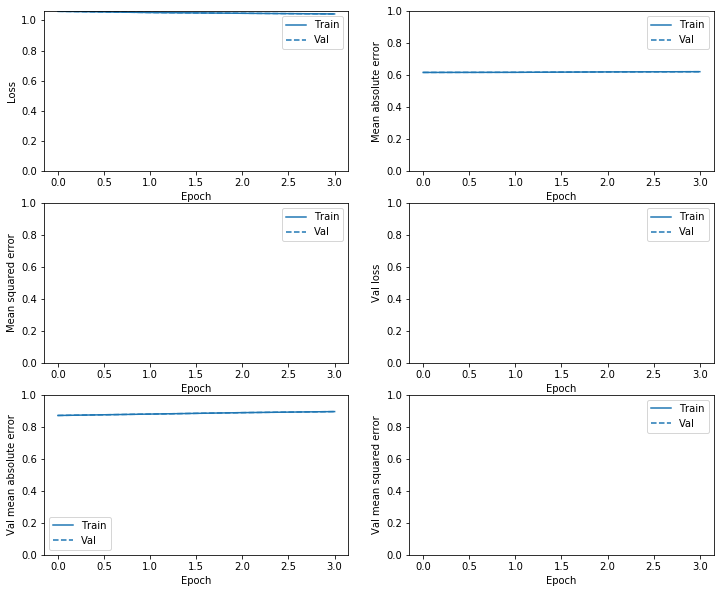

In [184]:
plot_metrics(history)

In [185]:
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 4.1665 - mean_absolute_error: 0.8958 - mean_squared_error: 4.1665


In [186]:
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

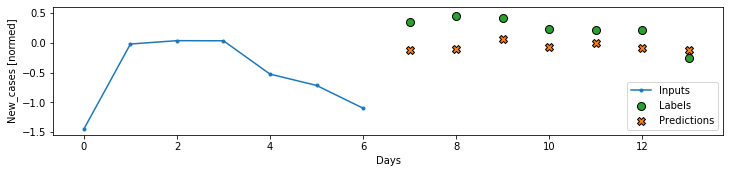

In [187]:
multi_window.plot(multi_dense_model)

In [188]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/50
3/3 [==============================] - 1s 190ms/step - loss: 1.0610 - mean_absolute_error: 0.6163 - mean_squared_error: 1.0610 - val_loss: 4.1475 - val_mean_absolute_error: 0.8704 - val_mean_squared_error: 4.1475
Epoch 2/50
3/3 [==============================] - 0s 24ms/step - loss: 1.0604 - mean_absolute_error: 0.6161 - mean_squared_error: 1.0604 - val_loss: 4.1472 - val_mean_absolute_error: 0.8703 - val_mean_squared_error: 4.1472
Epoch 3/50
3/3 [==============================] - 0s 24ms/step - loss: 1.0600 - mean_absolute_error: 0.6162 - mean_squared_error: 1.0600 - val_loss: 4.1472 - val_mean_absolute_error: 0.8703 - val_mean_squared_error: 4.1472
Epoch 4/50
3/3 [==============================] - 0s 24ms/step - loss: 1.0597 - mean_absolute_error: 0.6164 - mean_squared_error: 1.0597 - val_loss: 4.1473 - val_mean_absolute_error: 0.8701 - val_mean_squared_error: 4.1473
Epoch 5/50
3/3 [==============================] - 0s 28ms/step - loss: 1.0590 - mean_absolute_error: 0.6165

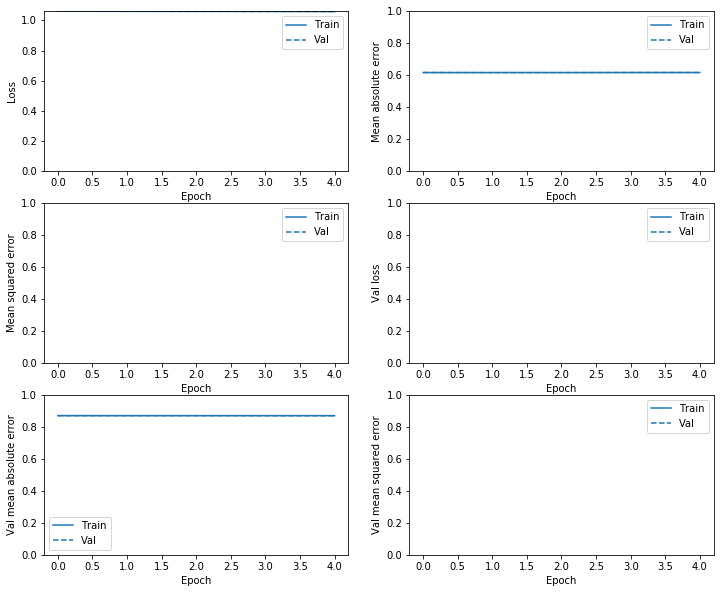

In [189]:
plot_metrics(history)

In [190]:
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 4.1475 - mean_absolute_error: 0.8701 - mean_squared_error: 4.1475


In [191]:
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

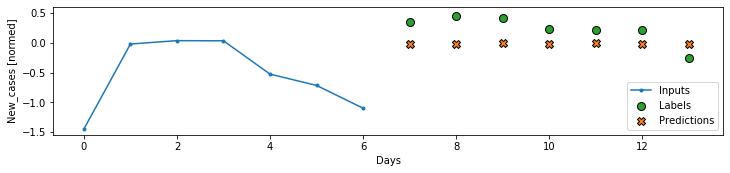

In [192]:
multi_window.plot(multi_lstm_model)

## AR model

In [193]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS, num_features=num_features)

In [194]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 1])

In [195]:
history = compile_and_fit(feedback_model, multi_window)

Epoch 1/50
3/3 [==============================] - 0s 142ms/step - loss: 1.0565 - mean_absolute_error: 0.6198 - mean_squared_error: 1.0565 - val_loss: 4.1416 - val_mean_absolute_error: 0.8779 - val_mean_squared_error: 4.1416
Epoch 2/50
3/3 [==============================] - 0s 25ms/step - loss: 1.0535 - mean_absolute_error: 0.6224 - mean_squared_error: 1.0535 - val_loss: 4.1501 - val_mean_absolute_error: 0.8821 - val_mean_squared_error: 4.1501
Epoch 3/50
3/3 [==============================] - 0s 25ms/step - loss: 1.0503 - mean_absolute_error: 0.6245 - mean_squared_error: 1.0503 - val_loss: 4.1513 - val_mean_absolute_error: 0.8838 - val_mean_squared_error: 4.1513


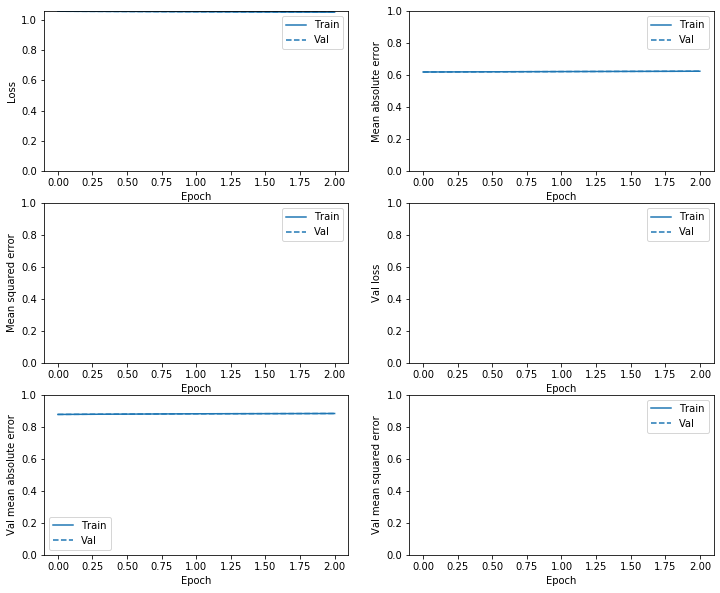

In [196]:
plot_metrics(history)

In [197]:
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 979us/step - loss: 4.1513 - mean_absolute_error: 0.8838 - mean_squared_error: 4.1513


In [198]:
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

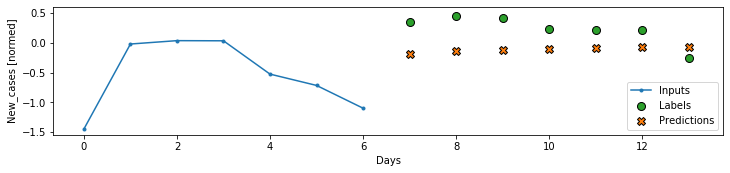

In [199]:
multi_window.plot(feedback_model)

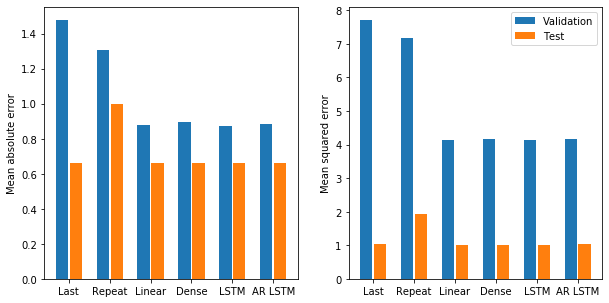

In [200]:
plot_comparison_results(multi_lstm_model.metrics_names, multi_val_performance, multi_performance)